In [ ]:
import numpy as np
import pandas as pd
import lmfit as lm
import os
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.special import erf,erfinv
from astropy.time import Time
from astropy import units as u
from astropy.io import fits

# Functions

In [13]:
def iso_to_mjd(row):
    '''convert ISOT to MJD'''
    date=Time(str(row.ISOT), format='iso') 
    date.format='mjd' # convert to ISO (YYYY-MM-DD)
    return date.value # convert to plot-able dates
    
def mjd_to_isot(row):
    '''convert MJD values into plot-able ISO dates'''
    isot=Time(row.MJD, format='mjd') # charge MJD dates with astropy
    isot.format='isot' # convert to ISO (YYYY-MM-DD)
    return np.datetime64(isot.value) # convert to plot-able dates

def sin_pola(x,C,a0,phi0):
    '''theoretical polarigram model'''
    return C*(1+a0*np.cos(2*(x-phi0)*(np.pi/180)))

############### DataFrame managment ###############

def charge_df(src, scw_file_name_list, plot=True, verbose=True, n_pola_bands=None):
    '''charge csv files of a source into dataframe'''
    df_pola_scw=pd.concat([pd.read_csv('saved_pola_df/{0}_{1}_pola.csv'.format(src,scw_file_name),
                        dtype={'SCW':'str','REV':'str'}) for scw_file_name in scw_file_name_list]) # charge all df in a list and concat them
    band_names=pd.unique([c.split('_')[0] for c in df_pola_scw.columns if '-' in c])
    if not n_pola_bands: # infer number of polarization bin from columns
        n_pola_bands = np.max([int(c.split('_')[1]) for c in df_pola_scw.columns if band_names[0] in c])+1
    df_pola_scw['scw_id']=df_pola_scw.apply(lambda x:x.SCW[:-4],axis=1)
    df_pola_scw['SCW_ORDER']=df_pola_scw.apply(lambda x:int(x.SCW[4:8]),axis=1)
    df_pola_scw.set_index('SCW')
    df_pola_scw['ISOT']=df_pola_scw.apply(lambda x:np.datetime64(x.ISOT),axis=1)
    df_pola_scw['YEAR']=df_pola_scw.apply(lambda x:x.ISOT.year,axis=1)
    df_pola_scw['MONTH']=df_pola_scw.apply(lambda x:x.ISOT.month,axis=1)
    if verbose:
        print('{0} scw found, {1} pola bands'.format(len(df_pola_scw),n_pola_bands))
        print(band_names)
    if plot:
        if len(df_pola_scw.YEAR.unique())<3: df_pola_scw.groupby('REV').REV.count().plot(kind="bar") # if only 1 year of data, plots the revs histogram
        else: df_pola_scw.groupby('YEAR').YEAR.count().plot(kind="bar")
        plt.ylabel('Number of scw')
        plt.plot()
    return df_pola_scw, band_names, n_pola_bands

def scw_selection(df, angle_max=None, rev_list=None, start_date=None, end_date=None, date_type='ISOT'):
    df = df.sort_values('ISOT',ignore_index=True)
    if angle_max: df=df[df.ANGLE<angle_max]
    if start_date: df=df[df[date_type]>=start_date]
    if end_date: df=df[df[date_type]<=end_date]
    if rev_list: df=df[df['REV'].isin(rev_list)]
    return df

############### Make polarigram ###############

def make_pola(df, band_names, spi_norm, comp_norm=1, verbose=True):
    ''' compute the average flux/error to create a polarigram from the flux df '''

    full_expo_time=df.EXPO.sum()
    all_pola_dico={'simple':{},'simple_clean':{}, 'pond':{}, 'pond_clean':{}}
    for b in tqdm(band_names):
        flux, flux_err=[],[]
        spicorr = spi_norm
        for p in range(n_pola_bands):
            name=b+'_'+str(p)
            df[name+'_count']= df.apply(lambda x:comp_norm*x[name]*x.EXPO-spicorr*x[name+'_spurf']*x['ISGRI_EXPO'], axis=1)
            df[name+'_count_err']= df.apply(lambda x:np.sqrt((comp_norm*x[name+'_err']*x.EXPO)**2 + (spicorr*x[name+'_spurf_err']*x['ISGRI_EXPO'])**2), axis=1)
            total_count=df[name+'_count'].sum()
            # average over all scw:
            flux.append(total_count/full_expo_time) # divide by full exposure to get count/s
            flux_err.append( np.sqrt((df[name+'_count_err']**2).sum()) / full_expo_time)
        all_pola_dico['simple'][b]=[flux,flux_err]
    if verbose:print('total expo= {0} ks'.format(int(full_expo_time/1000)))
    
    return all_pola_dico, df

def flux_band(x,b):
    '''compute total flux (in count/s) in 1 energy band of 1 scw'''
    f=0
    for p in range(n_pola_bands):
        f+=x['{0}_{1}_count'.format(b,p)]
    return f
def err_flux_band(x,b):
    '''compute total flux error in 1 energy band of 1 scw'''
    ferr=0
    for p in range(n_pola_bands):
        ferr+=(x['{0}_{1}_count_err'.format(b,p)])**2
    return np.sqrt(ferr)

def make_lc_sel(df_lc_scw, select_list, band_names,column_name):
    '''make a light-curve with each bin in select_list'''
    ### find the associated date in ISOT and MJD
    isot_mean_list, isot_diff_list, mjd_mean_list,mjd_diff_list=[],[],[],[]
    rev_mean_list,rev_diff_list,expo_list=[],[],[]
    for sel in select_list:
        df=df_lc_scw[df_lc_scw[column_name].isin(sel)]
        start,end=df.ISOT.min(), df.ISOT.max()
        isot_mean_list.append(start+(end-start)/2)
        isot_diff_list.append((end-start)/2)
        mjd_mean_list.append(df.MJD.mean())
        mjd_diff_list.append((df.MJD.max()-df.MJD.min())/2)
        mjd_list=np.int64(df.REV)
        rev_mean_list.append(mjd_list.mean())
        rev_diff_list.append((mjd_list.max()-mjd_list.min())/2)
        expo_list.append(df.EXPO.sum())
    dico_flux_sel={column_name:select_list, 'ISOT':isot_mean_list,'MJD':mjd_mean_list,'EXPO':expo_list, 'ISOT_diff':isot_diff_list,'MJD_diff':mjd_diff_list,
                'REV_mean':rev_mean_list, 'REV_diff':rev_diff_list}
    ### compute flux for each sub-df from the (total count)/(total expo)
    for b in band_names:
        df_lc_scw[b+'_count'] = df_lc_scw.apply(flux_band,args=(b,), axis=1) # scw counts in 1 energy band (sum over all pola bin)
        df_lc_scw[b+'_count_err'] = df_lc_scw.apply(err_flux_band, args=(b,), axis=1) # NEED A , AFTER THE FIRST ARGS (why I don't know)
        flux_sels,flux_err_sels,expo_sels=[],[],[]
        relative_flux,relative_flux_err=[],[]
        for sel in select_list:
            df=df_lc_scw[df_lc_scw[column_name].isin(sel)]
            tot_expo=df.EXPO.sum()
            flux_sels.append(df[b+'_count'].sum()/tot_expo) # count/s in 1 energy band over whole selection
            flux_err_sels.append(np.sqrt((df[b+'_count_err']**2).sum())/tot_expo)
        dico_flux_sel[b+'_flux'],dico_flux_sel[b+'_flux_err']=flux_sels,flux_err_sels
        dico_flux_sel[b+'_relative_flux'],dico_flux_sel[b+'_relative_flux_err']=flux_sels/np.mean(flux_sels), flux_err_sels/np.mean(flux_sels)
        
        #crab_norm=dico_crab_flux[b][0]
        #dico_flux_sel[b+'_crab'],dico_flux_sel[b+'_crab_err']=np.array(flux_sels)/crab_norm, np.array(flux_err_sels)/crab_norm
    df_lc=pd.DataFrame(dico_flux_sel)
    return df_lc

############### Probabilities ###############

def p_to_nsigma(p_unpola):
    '''compute the n-sigma significance from the proba of false detection
    technically this is not correct since polarigram parameters (a,phi0) are not normally distributed but it gives a quick interpretation of results
    This n-sigma value SHOULD NOT BE PUBLISHED
    '''
    return np.sqrt(2)*erfinv(1-p_unpola)

def proba_higher(result,a100, verbose=True):
    ''' finds the probability to have higher a0 then the one fitted, knowing the source is unpolarized (a0=0)
    P(a > a0 measured | a0 source = 0) '''
    c,sig_c =result.best_values['C'], result.data.std()
    a0=result.best_values['a0']
    z2=(n_pola_bands*c**2)/(2*sig_c**2)
    p_higher=(np.exp(-z2*a0**2) - np.exp(-z2*a100**2) )
    sigma_higher=p_to_nsigma(p_higher)
    # print('a0= {0} a100= {1}'.format(a0, a100))
    if verbose:
        print('p unpola=', p_higher)
        print('{0:.2f}-sigma detection'.format(sigma_higher))
    return p_higher, sigma_higher

############### Fit polarigram ###############

def a100_frac(Emin, Emax, pola_dico, pulsefrac_dir='compton_responses', pulsefrac_file='comps-prf-1.txt'):
    ''' calcul la moyenne de a100 pondérée par F(E)'''
    pulsefrac_path= '{}/{}'.format(pulsefrac_dir, pulsefrac_file)
    df_pf=pd.read_csv(pulsefrac_path,delim_whitespace=True, names=['E','compton_event','a100','a100_err'])
    spec_list = [ [int(e) for e in b.split('-')]+[np.sum(pola_dico[b][0])]+[np.sum(pola_dico[b][1])] for b in pola_dico]
    df_spec=pd.DataFrame(spec_list, columns=['Einf','Esup','Flux','Flux_err'])
    df_spec_born=df_spec[(df_spec.Einf>=Emin)&(df_spec.Esup<=Emax)]
    
    a100, Ftot = 0, 0
    dE=df_pf.E.iloc[1]-df_pf.E.iloc[0] # we suppose that f(E)=a100 has constant step
    for spec in df_spec_born.values:
        E1, E2, F, F_err= spec
        Ftot+=F*(E2-E1)
        a100 += F * df_pf[(df_pf.E>=E1)&(df_pf.E<E2)].a100.sum() # convolution of a100 with F
    
    return (a100*dE)/Ftot, df_spec_born

def phi_to_pa(phi_0, pa_mod):
    '''convert raw phi value into Polarization Angle (PA), with different references
    ref=0 : -90° < PA < 90°
    ref=90 : 0° < PA < 180°
    '''
    PA=phi_0 - 90
    if pa_mod=='PA_ref0': return PA - 180*(PA>90) # substract 180° if above 90°
    elif pa_mod=='PA_ref90': return PA + 180*(PA<0) # add 180° if below 0°
    else: return PA 

def combine_bands(e_min, e_max, band_names):
    '''finds the biggest interval inside [e_min, e_max] from pola_dico'''
    bands=[]
    for b in band_names:
        e1,e2=b.split('-')
        if int(e1)>=int(e_min) and int(e2)<=int(e_max): bands.append(b)
    if len(bands)==0:
        print('no energy bands found !')
        # print(pola_dico.keys())
    return bands

def a0_upper_lim(result,a100,p=0.01,verbose=True):
    '''this gives an estimate of upper-limits by inverting the probability formula (see Bouchet+2024, A&A)'''
    c,sig_c = result.best_values['C'], result.data.std()#result.params.get('C').stderr
    z2 = (n_pola_bands*c**2)/(2*sig_c**2)
    a_up = np.sqrt(-(1/z2)*np.log(p + np.exp(-z2*a100**2)))
    if verbose:
        print('upper-limits: a0:{0:.3f}, PF:{1:.3f}'.format(a_up, a_up/a100))
    return a_up

def fit_pola(pola_dico,bands,verbose=True, weighted=True, folded=1,article=False, pa_mod=None,bottom=0.,top=1.):
    '''fit the polarigram and deduce PA/PF values'''

    ### add the different bands together
    y=np.zeros(n_pola_bands)
    y_err=np.zeros(n_pola_bands)
    for b in bands:
        y+=pola_dico[b][0]
        y_err+=np.array(pola_dico[b][1])**2
    y_err=np.sqrt(y_err)

    # dividing count-rates by bin angle width allows to have "invariant polarigrams" = independant of binning (similar to flux/keV for spectra)
    # folded=1 is the default, folded=0 means the polarigram was not folded on [0,pi] during ic_PolaIma computation (only for testing purpose)
    bin_width= (2-folded)*np.pi/n_pola_bands # bin width in radian
    y = y/(bin_width*(1+folded))
    y_err = y_err/(bin_width*(1+folded))

    SNR = y.sum()/np.sqrt(np.sum(y_err**2))
    Emin, Emax = bands[0].split('-')[0],bands[-1].split('-')[1]
    a100, df_spec_born = a100_frac(int(Emin), int(Emax), pola_dico) # compute a100 for the given energy range
    pola_width = ((2-folded)*180/n_pola_bands) # 180° if folded, 360° if not 
    x_pola = np.array([pola_width*(i+1/2) for i in range(n_pola_bands)]) # convert pola bin to angle phi
    #y_test=np.random.normal(0.1, np.mean(pola_dico[b][0]), n_pola_bands)

    ### fit polarigram
    mean_y=np.mean(y)
    par_pola= lm.Parameters()
    par_pola.add('C',value=mean_y)
    if folded: par_pola.add('a0',value=(np.max(y)-mean_y)/mean_y)
    else: par_pola.add('a0',value=(np.max(y)-mean_y)/mean_y,min=0)
    max_phi=x_pola[np.argmax(y)] # angle of maximum flux
    par_pola.add('phi0',value=max_phi) # no constraint on phi0, this is preferred
    
    gmodel = lm.Model(sin_pola)
    
    ### fit with constant to compare Chi2
    par_nopola= lm.Parameters()
    par_nopola.add('c',value=mean_y)
    gmodel_nopola = lm.models.ConstantModel()
    if weighted: # does not change result since y_err is pretty much constant, but gives chi2 value
        result = gmodel.fit(y, par_pola, x=x_pola, weights=1/y_err)
        result_nopola = gmodel_nopola.fit(y, par_nopola, x=x_pola, weights=1/y_err)
        print('reduced chi2: pola={0}, no pola={1}'.format(result.redchi, result_nopola.redchi))
    else: result = gmodel.fit(y, par_pola, x=x_pola)
    p_higher, sigma_higher = proba_higher(result,a100, verbose=False)

    ### plot the result
    x_model=np.linspace(np.min(x_pola),np.max(x_pola), num=500)
    x_model_360=np.linspace(np.min(x_pola),360, num=500)
    
    if verbose:
        print('Polarized flux in '+Emin+'-'+Emax+' keV band')

        fig, ax = plt.subplots(figsize=(8,5))
        label_font=15
        label_fit='PA = {0:.1f} ± {1:.1f} °'.format(phi_to_pa(result.best_values['phi0'], pa_mod),result.params.get('phi0').stderr)+\
                '\nPF = {0:.2f} ± {1:.2f} %\nSNR = {2:.1f}'.format(100*result.best_values['a0']/a100,100*result.params.get('a0').stderr/a100,SNR)
        label_data=''
        ax.axhline(y=result.best_values['C'],color='grey',ls='--')
        ax.axhline(y=0,color='k')
        if folded:
            ax.errorbar(x=np.concatenate((x_pola,(x_pola+180))), y=np.concatenate((y,y)), # duplicates the [0,pi] polarigram to be on [0,2*pi]
                        yerr=np.concatenate((y_err,y_err)), xerr=pola_width/2, fmt='k.', label=label_data) 
            ax.plot(x_model_360, result.eval(x=x_model_360), 'r-', label=label_fit)
        else:
            ax.errorbar(x=x_pola, y=y, yerr=y_err,xerr=pola_width/2, fmt='.', label=label_data)
            ax.plot(x_model, result.eval(x=x_model), 'r-', label=label_fit)
        ax.xaxis.label.set_size(label_font);ax.yaxis.label.set_size(label_font);ax.tick_params(which='both', labelsize=label_font)
        ax.set_xlabel('$\phi$ (°)');ax.set_ylabel(r'Counts s$^{-1}$ rad$^{-1}$')
        plt.legend(loc='best',fontsize=14);plt.grid(True);plt.show()

        print('mean flux = {0} ± {1} ct/s/rad'.format(np.mean(y), np.std(y)),' a0*C={0}'.format(result.best_values['a0']*result.best_values['C']))
        print('total flux = {0:.4f} ± {1:.4f} ct/s'.format(df_spec_born.Flux.sum(), np.sqrt(np.sum(df_spec_born.Flux_err**2))))
        print('SNR = {0:.1f} P(no pola) = {1:.5f} -> {2:.1f}-sigma detection'.format(SNR,p_higher,sigma_higher))
        # print('a0 = {0:.3f},  a100 = {1:.3f}'.format(result.best_values['a0'],a100))
        print('PA = {0:.1f} ± {1:.1f}'.format(phi_to_pa(result.best_values['phi0'], pa_mod),result.params.get('phi0').stderr) )
        print('PF = {0:.2f} ± {1:.2f}'.format(result.best_values['a0']/a100,result.params.get('a0').stderr/a100) )
        
    return result,a100,SNR, df_spec_born

def pola_select(df_pola_all_scw, column_name,select_list, bands, pola_dico_name, select_names=None, verbose=True,soft='old',spi_norm=.9,comp_norm=1.,
                sigma_threshold=2.5,SNR_threshold=12,pa_mod='PA_ref0',off_angle=5.,folded=1,calc_spicorr=False):
    '''select from df by a certain column (year or rev) and fit polarigram'''
    
    list_pola_select=[]
    for i,sel in enumerate(select_list):
        if verbose:
            print('\n\n*** -------------------------------------------------------------------------\n',sel)
        if select_names and verbose: print('grouping name:', select_names[i])
        df=df_pola_all_scw[df_pola_all_scw[column_name].isin(sel)]
        df=df[df.ANGLE<off_angle]
        all_pola_dico,_ = make_pola(df,bands,soft=soft,spi_norm=spi_norm,comp_norm=comp_norm, verbose=verbose)
        print(pola_dico_name)
        pola_dico=all_pola_dico[pola_dico_name]
        try:  #pola_dico,bands,verbose=True, weighted=True, full_360=1,article=False, pa_mod='PA_ref0'
            result,a100,SNR, df_spec_born=fit_pola(all_pola_dico[pola_dico_name],bands,verbose=verbose,weighted=False,folded=folded,pa_mod=pa_mod)
            p_higher, sigma_higher = proba_higher(result,a100, verbose=False)
            lolim=0
            print(sigma_higher)
            start,end=df.ISOT.min(), df.ISOT.max()
            isot_diff=(end-start)
            isot_mean=start+isot_diff/2
            flux=df_spec_born.Flux.sum()

            if  SNR>SNR_threshold:
                ampli=result.params.get('a0').value*result.params.get('C').value
                ampli_err= ampli* np.sqrt((result.params.get('a0').stderr/result.params.get('a0').value)**2+(result.params.get('C').stderr/result.params.get('C').value)**2)
                if sigma_higher>=sigma_threshold:
                    uplim=0
                    a_0=result.best_values['a0']
                    PA = phi_to_pa(result.best_values['phi0'], pa_mod)
                else:
                    uplim=1
                    a_0 = a0_upper_lim(result,a100,p=0.01,verbose=verbose)
                    PA = np.nan

                list_pola_select.append([sel,isot_mean, isot_diff/2, int(df.EXPO.sum()/1000),SNR,
                        PA, result.params.get('phi0').stderr, a_0/a100,result.params.get('a0').stderr/a100,
                        result.redchi,ampli,ampli_err,flux,uplim,lolim])
            else:
                list_pola_select.append([sel,isot_mean, isot_diff/2, int(df.EXPO.sum()/1000),SNR,
                        None, None, None,None, None,None,None,flux,None,None])
                

        except ValueError:
            print('nan value in fit for '+src+' '+sel)
            continue
    return pd.DataFrame(list_pola_select, columns=[column_name,'ISOT','ISOT_diff', 'Expo (ks)','SNR' ,'PA','PA_err',
                        'PF','PF_err','red Chi2','ampli','ampli_err','flux','uplims','lolims'])#,dtype={'uplims':'bool'} 

def pola_espectrum(pola_dico_plot, energy_bands, pa_mod='PA_ref90', SNR_threshold=12, sigma_threshold=2.5, p_uplim=0.01, verbose=0):
    '''find best fit PA/PF in all energy bands if detection is significant enough, and returns df for plot'''

    list_pola_param=[]
    for band in energy_bands:
        try:
            if verbose: print('\n\n*** -------------------------------------------------------------------------\n')
            e_min, e_max = band.split('-')
            bands = combine_bands(e_min, e_max, pola_dico_plot)
            result, a100, SNR, df_spec_born = fit_pola(pola_dico_plot,bands,verbose=1, article=0, weighted=0, pa_mod=pa_mod, folded=1)
            p_higher, sigma_higher = proba_higher(result, a100, verbose=False)
            if  SNR>SNR_threshold: # if the SNR is sufficient for meaningful detection
                flux=df_spec_born.Flux.sum()
                ampli=result.params.get('a0').value*result.params.get('C').value
                ampli_err= ampli* np.sqrt((result.params.get('a0').stderr/result.params.get('a0').value)**2+(result.params.get('C').stderr/result.params.get('C').value)**2)
                if sigma_higher>sigma_threshold: # if polarization is detected, a0/phi0 from fit are kept
                    uplim=0
                    a_0=result.best_values['a0']
                    phi_0=result.best_values['phi0']
                else: # otherwise use upper-limit
                    uplim=1
                    a_0 = a0_upper_lim(result,a100,p=p_uplim,verbose=1)
                    phi_0 = np.nan

                list_pola_param.append([e_min,e_max, phi_to_pa(phi_0, pa_mod), result.params.get('phi0').stderr, 
                a_0/a100,result.params.get('a0').stderr/a100,result.redchi,SNR,ampli,ampli_err,flux,uplim])
        except ValueError: # this can happen for empty energy bands or negative flux
            print('nan value in fit for '+bands+ ' keV band')
            continue

    df_pola_param=pd.DataFrame(list_pola_param, columns=['E_min','E_max','PA','PA_err','PF','PF_err','red Chi2','SNR','ampli','ampli_err','flux','uplims'])
    df_pola_param['E_mean'] =df_pola_param.apply(lambda x:(int(x.E_min)+int(x.E_max))/2, axis=1 )
    df_pola_param['dE'] =df_pola_param.apply(lambda x:(int(x.E_max)-int(x.E_min))/2, axis=1 )
    df_pola_param['PF_pct'] =df_pola_param.PF*100
    df_pola_param['PF_err_pct'] =df_pola_param.PF_err*100
    df_pola_param['uplims_pct'] =df_pola_param.uplims*100
    # df_pola_param[pa_mod]=df_pola_param.apply(lambda x:x.PA-180 if (x.PA>90) else x.PA, axis=1)
    return df_pola_param

def plot_polar_espectrum(df, plot_scale='lin', plot_grid=0, with_snr=0, fmt='k.'):
    if with_snr: fig,ax=plt.subplots(3,1,figsize=(10,10))
    else: fig,ax=plt.subplots(2,1,figsize=(10,8))

    # Polarization Angle (PA) = upper plot
    ax[0].errorbar('E_mean', 'PA', yerr='PA_err',xerr='dE', fmt=fmt, data=df, label=None)
    ax[0].axhline(df['PA'].mean(),linestyle='--',c='k',label='Average PA = {0:.1f} ± {1:.1f} °'.format(df['PA'].mean(),df['PA'].std()))
    ax[0].set_ylabel('PA')
    # ax[0].tick_params(labelbottom=False) 
    ax[0].legend(loc='upper right')#;ax[1].legend()#

    ax[1].errorbar('E_mean','PF',yerr='PF_err',xerr='dE',fmt=fmt,  data=df,label=None, uplims=df['uplims'])
    #ax[1].axhline(df['PF'].mean(),linestyle='--',c='k',label='Average PF = {0:.2f} ± {1:.2f}'.format(df['PF'].mean(),df['PF'].std()))
    ax[1].set_ylabel('PF')
    ax[1].set_ylim(bottom=0,top=1.)
    ax[0].set_xlim(ax[1].get_xlim()) # to have the same x axis in case there are upper-limits

    if with_snr: # plot the SNR of each energy band
        ax[2].errorbar('E_mean','SNR',xerr='dE',fmt=fmt,  data=df)
        ax[2].set_ylabel('SNR');ax[2].set_xlabel('E (keV)')
        ax[2].legend()
    else: ax[1].set_xlabel('E (keV)')

    for i in range(len(ax)): # other plot parameters
        ax[i].xaxis.label.set_size(16);ax[i].yaxis.label.set_size(16)
        ax[i].tick_params(which='both', labelsize=16)
        if plot_grid==True: ax[i].grid(True);ax[i].grid(True)
        if plot_scale=='log': ax[i].set_xscale('log');ax[i].set_xscale('log')

    #ax[0].set_title('{0} polarigram parameters with energy'.format(src))


# Polarization analysis

import the data frame(s) with raw fluxes

In [ ]:
src='crab'
scw_file_name_list=['100scw'] # several df can be combined (energy/pola bins need to match)
plot_scw=1 # to plot the distribution of the over time/revs

if plot_scw: fig, ax= plt.subplots(1,1,figsize=(7,6))
df_pola_scw, band_names, n_pola_bands = charge_df(src, scw_file_name_list, plot=plot_scw, n_pola_bands=None)

some further selection on off-axis angle, date, revolution number, etc... can be done

In [ ]:
angle_max=5.
# date_type, start_date, end_date= 'ISOT', '2018-01-01','2023-01-01' # ex using ISOT
# date_type, start_date, end_date= 'MJD', 58500, 65000 # ex using MJD
date_type, start_date, end_date= None, None, None

df_pola_scw_sel = scw_selection(df_pola_scw, angle_max=angle_max, rev_list=None, start_date=start_date, end_date=end_date, date_type=date_type)
warnings.filterwarnings("ignore")
print('{0} scw selected (avg off-axis angle = {1:.1f}°)'.format(len(df_pola_scw_sel.SCW.unique()),df_pola_scw_sel.ANGLE.mean()))
all_pola_dico, df_pola_scw_sel = make_pola(df_pola_scw_sel, band_names, spi_norm=.9, comp_norm=1.)#



*** -------------------------------------------------------------------------

Polarized flux in 200-300 keV band


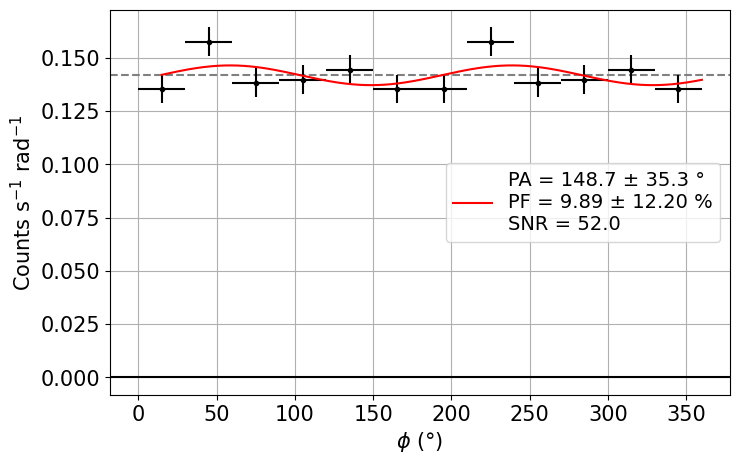

mean flux = 0.14181001413482416 ± 0.007726561226826163 ct/s/rad  a0*C=0.004633386916732693
total flux = 0.8910 ± 0.0420 ct/s
SNR = 52.0 P(no pola) = 0.34000 -> 1.0-sigma detection
PA = 148.7 ± 35.3
PF = 0.10 ± 0.12
upper-limits: a0:0.068, PF:0.204


*** -------------------------------------------------------------------------

Polarized flux in 300-400 keV band


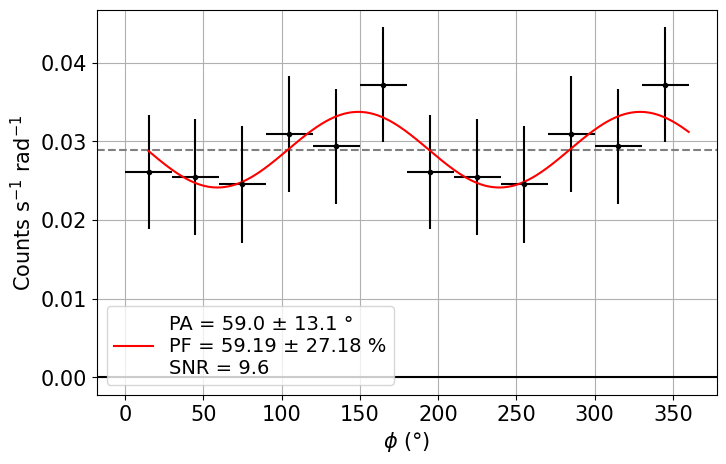

mean flux = 0.028939442894433093 ± 0.004333785942847791 ct/s/rad  a0*C=0.00480938476154156
total flux = 0.1818 ± 0.0462 ct/s
SNR = 9.6 P(no pola) = 0.02483 -> 2.2-sigma detection
PA = 59.0 ± 13.1
PF = 0.59 ± 0.27


*** -------------------------------------------------------------------------

Polarized flux in 400-600 keV band


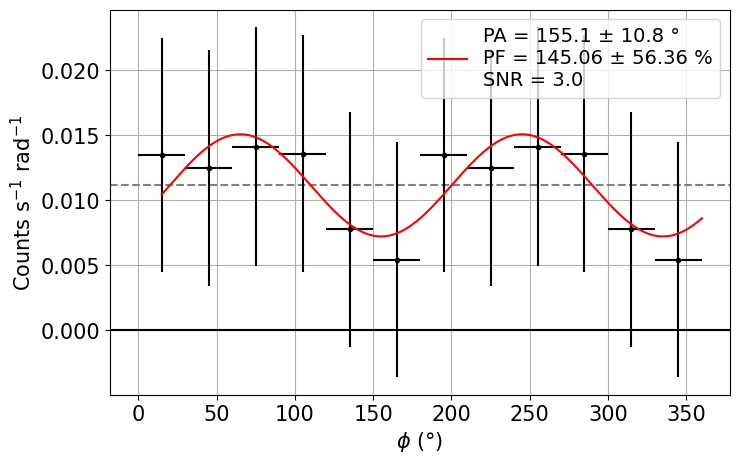

mean flux = 0.011156257490395017 ± 0.0033171758841133076 ct/s/rad  a0*C=0.003927765049612253
total flux = 0.0701 ± 0.0571 ct/s
SNR = 3.0 P(no pola) = -0.12058 -> nan-sigma detection
PA = 155.1 ± 10.8
PF = 1.45 ± 0.56


*** -------------------------------------------------------------------------

Polarized flux in 600-1000 keV band


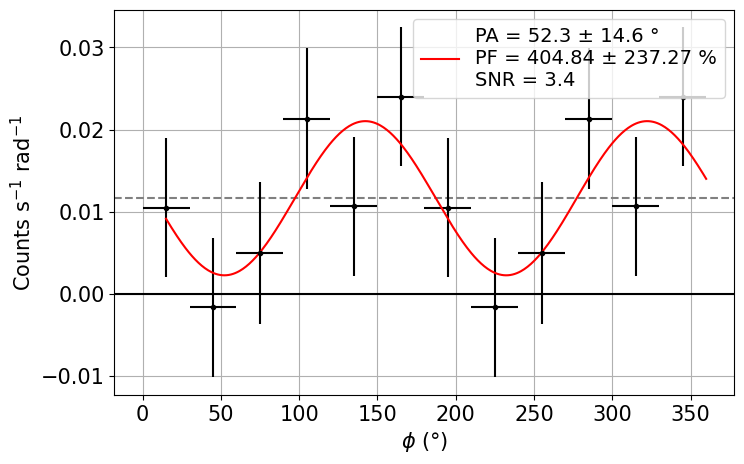

mean flux = 0.011640740110788979 ± 0.008842763598589352 ct/s/rad  a0*C=0.009378699402772953
total flux = 0.0731 ± 0.0534 ct/s
SNR = 3.4 P(no pola) = -0.77968 -> nan-sigma detection
PA = 52.3 ± 14.6
PF = 4.05 ± 2.37


*** -------------------------------------------------------------------------

Polarized flux in 1000-2000 keV band


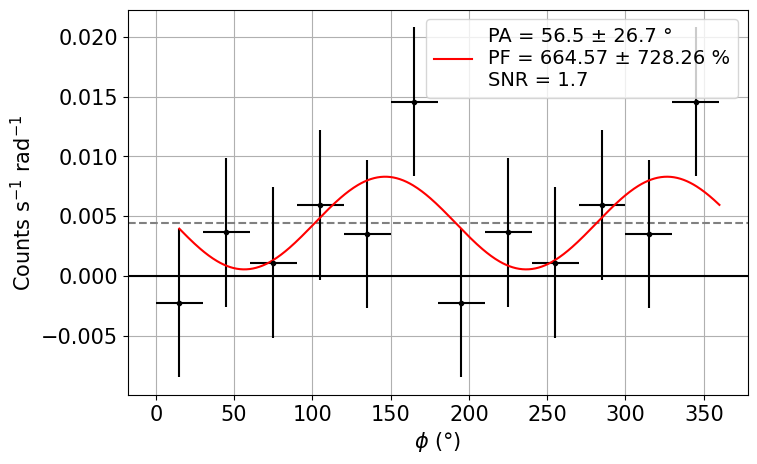

mean flux = 0.00442026570663545 ± 0.005201354952739209 ct/s/rad  a0*C=0.003875542072394634
total flux = 0.0278 ± 0.0393 ct/s
SNR = 1.7 P(no pola) = -0.77390 -> nan-sigma detection
PA = 56.5 ± 26.7
PF = 6.65 ± 7.28


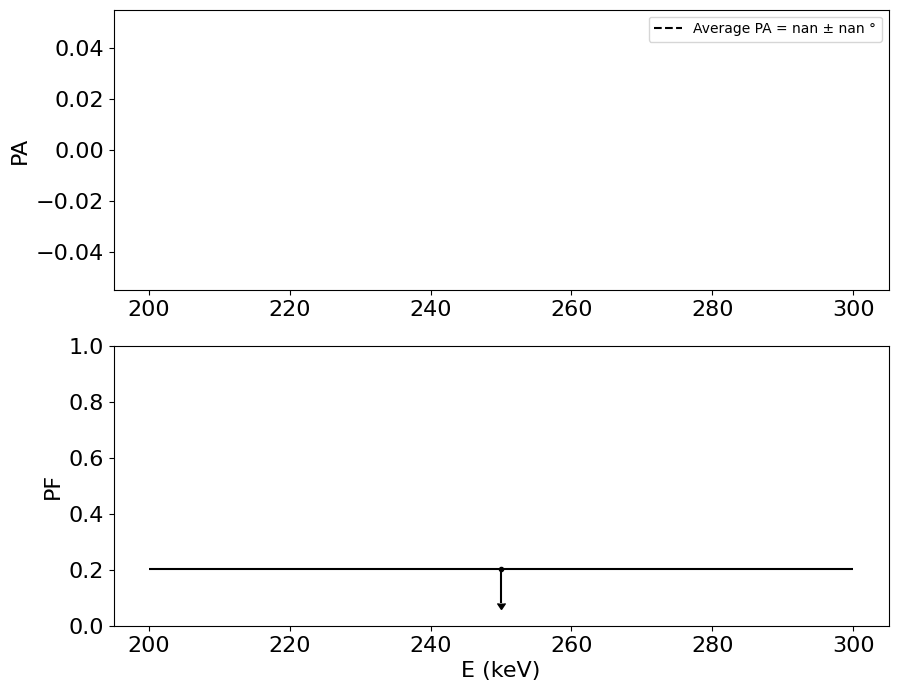

In [14]:
sigma_threshold = 2.5
SNR_threshold = 12.
pa_mod= 'PA_ref90'
plot_scale='lin' # 'log'

# different energy bands can be chosen by combining the default ones
energy_bands = list(all_pola_dico['simple'].keys()) # default energy bands
# energy_bands = ['200-250', '250-300', '300-400'] # example of bigger energy bins

df_pola_param = pola_espectrum(all_pola_dico['simple'], energy_bands, pa_mod=pa_mod, SNR_threshold=SNR_threshold, sigma_threshold=sigma_threshold, verbose=1)
plot_polar_espectrum(df_pola_param, plot_scale=plot_scale, plot_grid=0, with_snr=0) # plot the polarization parameters with energy